# Exploration and Comparison of Transformers for Image Classification

## Fine-tuning (optimized) using Vision Transformer (ViT)

Fine-tuning is an experiment that involves training the entire model on the new task. All of model's parameters are end-to-end fine-tuned on the provided dataset.

The resulting model's performance is the measured on the test split with accuracy metric.

TODO: talk about the optimalization + data aug

### Vision Transformer (ViT)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. It was introduced in the paper *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al.*

https://arxiv.org/abs/2010.11929

### Prerequisites

Load necessary packages.

In [5]:
import os
import random

os.chdir("../../")

import pandas as pd
import torch
from datasets import DatasetDict, concatenate_datasets, load_dataset
from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *
from utils.config import *
from utils.data_utils import *
from utils.models_utils import *
from utils.train_utils import *
from utils.visualization_utils import *

Check if there is GPU available.

In [6]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe
VRAM: 79.25 GB


Set manual seed for reproducibility.

In [7]:
id = 10
random.seed(id)
torch.manual_seed(10)

Load ViT image processor used for image pre-processing.

In [8]:
processor = get_backbone_processor(model_names["ViT"])

Print the pre-processing operations done by the processor.

In [9]:
processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

NOTE: For this experiment, a validation set is required. Since some of the datasets don't have one, it is necessary to create one from a part of the training set.

Processor is automatically applied to each image.

#### RESISC45

In [29]:
resisc45 = load_dataset("timm/resisc45")
clean_labels(resisc45, name="resisc45")
resisc45_train = ImageDataset(
    dataset=resisc45["train"],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45["validation"],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45["test"],
    processor=processor,
)

In [30]:
resisc45

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 18900
    })
    validation: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 6300
    })
    test: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 6300
    })
})

#### Food-101

In [12]:
food101 = load_dataset("ethz/food101")
clean_labels(food101, name="food101")

In [13]:
_food101 = food101["train"].train_test_split(test_size=0.333, seed=id)
food101 = DatasetDict(
    {
        "train": _food101["train"],
        "validation": _food101["test"],
        "test": food101["validation"],
    }
)

In [14]:
food101_train = ImageDataset(
    dataset=food101["train"],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101["validation"],
    processor=processor,
)
food101_test = ImageDataset(
    dataset=food101["test"],
    processor=processor,
)

In [15]:
food101

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 50525
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25225
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

#### FER2013

In [16]:
fer2013 = load_dataset("AutumnQiu/fer2013")
clean_labels(fer2013, name="fer2013")
fer2013_train = ImageDataset(
    dataset=fer2013["train"],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013["valid"],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013["test"],
    processor=processor,
)

In [17]:
fer2013

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 28709
    })
    valid: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
})

#### PCam

In [18]:
pcam = load_dataset("zacharielegault/PatchCamelyon")
clean_labels(pcam, name="pcam")
pcam_train = ImageDataset(
    dataset=pcam["train"],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam["validation"],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam["test"],
    processor=processor,
)

In [19]:
pcam

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 262144
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
})

#### SUN397

In [20]:
sun397 = load_dataset("dpdl-benchmark/sun397")
clean_labels(sun397, name="sun397")
sun397_train = ImageDataset(
    dataset=sun397["train"],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397["validation"],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397["test"],
    processor=processor,
)

In [21]:
sun397

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 76127
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 21750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10875
    })
})

#### DTD

In [22]:
dtd = load_dataset("tanganke/dtd")
clean_labels(dtd, name="dtd")

In [23]:
_dtd = dtd["train"].train_test_split(test_size=0.1, seed=id)
dtd = DatasetDict(
    {
        "train": _dtd["train"],
        "validation": _dtd["test"],
        "test": dtd["test"],
    }
)

In [24]:
dtd_train = ImageDataset(
    dataset=dtd["train"],
    processor=processor,
)
dtd_validation = ImageDataset(
    dataset=dtd["validation"],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd["test"],
    processor=processor,
)

In [25]:
dtd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3384
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 376
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1880
    })
})

### Data Augmentation

TODO: text

In [31]:
augmentations = get_data_augmentations()
augmentations

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomInvert(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.3, 0.3))
)

#### RESISC45

In [32]:
sample = resisc45["train"].train_test_split(train_size=0.15, seed=id)["train"]
resisc45_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [33]:
resisc45_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 2835/2835 [01:29<00:00, 31.74 examples/s]

Augmentation completed. Total number of new samples generated: 2835


In [34]:
resisc45_train_augmented = concatenate_datasets(
    [resisc45_train.dataset, resisc45_train_sample.dataset]
)

In [35]:
resisc45_train = ImageDataset(
    dataset=resisc45_train_augmented,
    processor=processor,
)

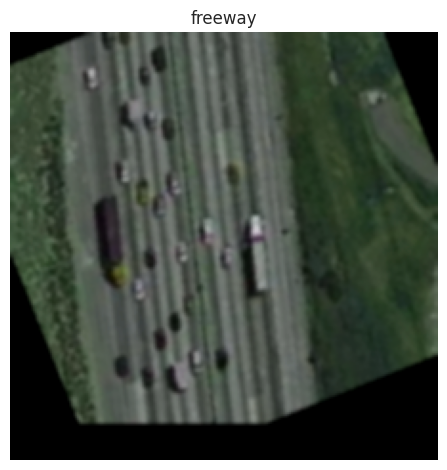

In [36]:
resisc45_train.plot_image(-1)

#### Food-101

In [37]:
sample = food101["train"].train_test_split(train_size=0.15, seed=id)["train"]
food101_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [38]:
food101_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 7578/7578 [04:08<00:00, 30.45 examples/s]

Augmentation completed. Total number of new samples generated: 7578


In [39]:
food101_train_augmented = concatenate_datasets(
    [food101_train.dataset, food101_train_sample.dataset]
)

In [40]:
food101_train = ImageDataset(
    dataset=food101_train_augmented,
    processor=processor,
)

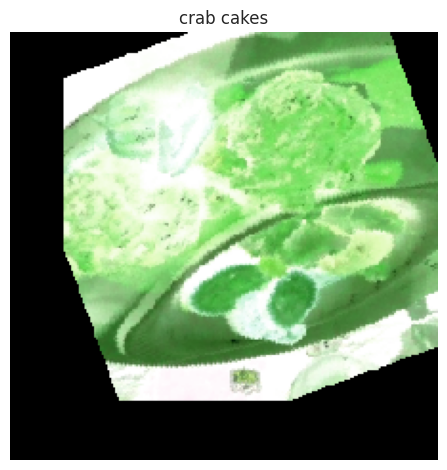

In [41]:
food101_train.plot_image(-1)

#### FER2013

In [42]:
sample = fer2013["train"].train_test_split(train_size=0.15, seed=id)["train"]
fer2013_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [43]:
fer2013_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 4306/4306 [01:09<00:00, 62.36 examples/s]

Augmentation completed. Total number of new samples generated: 4306


In [44]:
fer2013_train_augmented = concatenate_datasets(
    [fer2013_train.dataset, fer2013_train_sample.dataset]
)

In [45]:
fer2013_train = ImageDataset(
    dataset=fer2013_train_augmented,
    processor=processor,
)

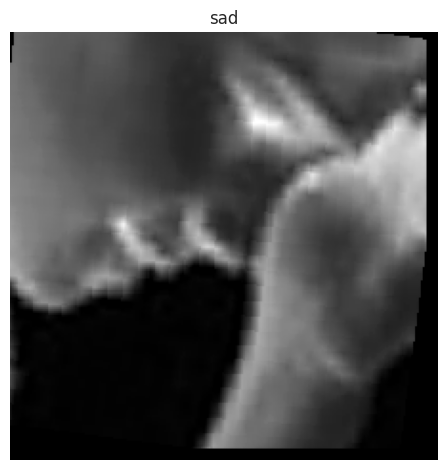

In [46]:
fer2013_train.plot_image(-1)

#### PCam

In [47]:
sample = pcam["train"].train_test_split(train_size=0.15, seed=id)["train"]
pcam_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [48]:
pcam_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 39321/39321 [18:06<00:00, 36.19 examples/s]

Augmentation completed. Total number of new samples generated: 39321


In [49]:
pcam_train_augmented = concatenate_datasets(
    [pcam_train.dataset, pcam_train_sample.dataset]
)

In [50]:
pcam_train = ImageDataset(
    dataset=pcam_train_augmented,
    processor=processor,
)

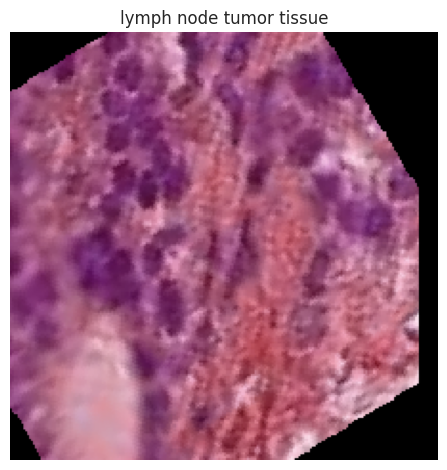

In [51]:
pcam_train.plot_image(-1)

#### SUN397

In [52]:
sample = sun397["train"].train_test_split(train_size=0.15, seed=id)["train"]
sun397_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [53]:
sun397_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 11419/11419 [06:24<00:00, 29.73 examples/s]

Augmentation completed. Total number of new samples generated: 11419


In [54]:
sun397_train_augmented = concatenate_datasets(
    [sun397_train.dataset, sun397_train_sample.dataset]
)

In [55]:
sun397_train = ImageDataset(
    dataset=sun397_train_augmented,
    processor=processor,
)

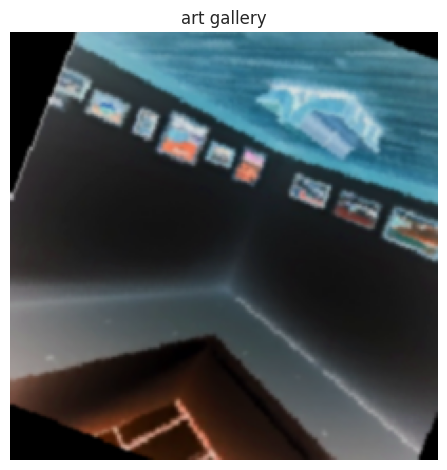

In [56]:
sun397_train.plot_image(-1)

#### DTD

In [57]:
sample = dtd["train"].train_test_split(train_size=0.15, seed=id)["train"]
dtd_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [58]:
dtd_train_sample.augment_dataset(augmentations=augmentations, batch_size=64)

Map: 100%|██████████| 507/507 [00:16<00:00, 30.63 examples/s]

Augmentation completed. Total number of new samples generated: 507


In [59]:
dtd_train_augmented = concatenate_datasets(
    [dtd_train.dataset, dtd_train_sample.dataset]
)

In [60]:
dtd_train = ImageDataset(
    dataset=dtd_train_augmented,
    processor=processor,
)

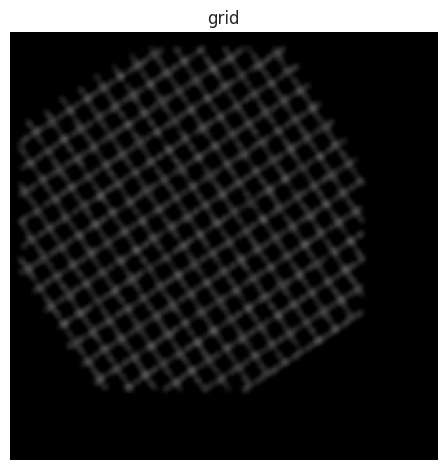

In [61]:
dtd_train.plot_image(-1)

### Config

Create a config for experiments and print its settings.

In [62]:
scheduler = SchedulerConfig(
    enabled=True,
    warmup_epochs=3,
    eta_min=1e-7,
    linear_start_factor=0.1,
    linear_end_factor=1.0,
)
scheduler.get_scheduler_settings()

{'enabled': True,
 'warmup_epochs': 3,
 'eta_min': 1e-07,
 'linear_start_factor': 0.1,
 'linear_end_factor': 1.0}

In [63]:
gradient_clipping = GradientClippingConfig(enabled=True, max_norm=2.0)
gradient_clipping.get_clipping_settings()

{'enabled': True, 'max_norm': 2.0}

In [64]:
early_stopping = EarlyStoppingConfig(
    enabled=True,
    patience=5,
    delta=0.005,
)
early_stopping.get_early_stopping_settings()

{'enabled': True, 'patience': 5, 'delta': 0.005}

In [65]:
from torch.optim import AdamW

config = Config(
    batch_size=64,
    num_epochs=15,
    lr=5e-5,
    optimizer=AdamW,
    weight_decay=1e-2,
    dropout_rate=0.5,
    early_stopping=early_stopping,
    gradient_clipping=gradient_clipping,
    scheduler=scheduler,
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 64,
 'lr': 5e-05,
 'num_epochs': 15,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0.01,
 'dropout_rate': 0.5,
 'early_stopping': {'enabled': True, 'patience': 5, 'delta': 0.005},
 'gradient_clipping': {'enabled': True, 'max_norm': 2.0},
 'scheduler': {'enabled': True,
  'warmup_epochs': 3,
  'eta_min': 1e-07,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Plot the learning rate curve from scheduling settings.

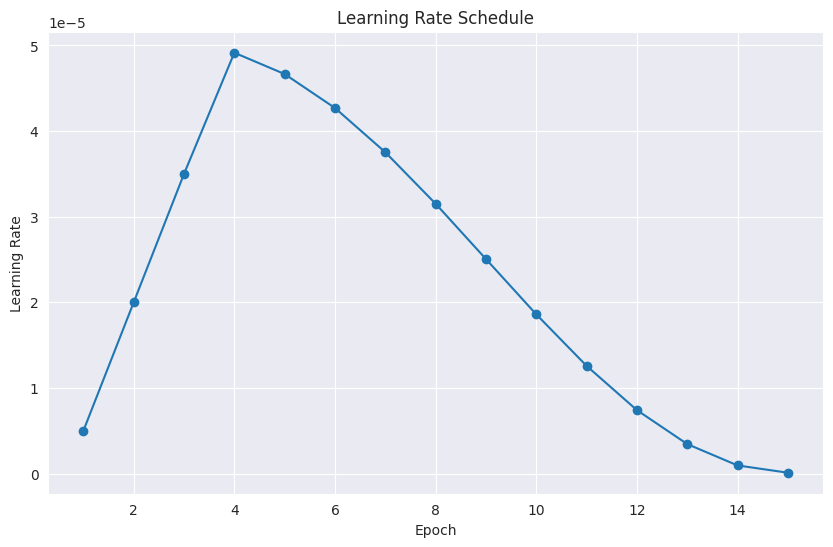

In [66]:
plot_learning_rate_scheduling(
    num_epochs=config.num_epochs,
    num_warmup_epochs=config.scheduler.warmup_epochs,
    linear_start_factor=config.scheduler.linear_start_factor,
    linear_end_factor=config.scheduler.linear_end_factor,
    base_lr=config.lr,
    eta_min=config.scheduler.eta_min,
)

Create empty array to store dataset accuracies for each experiment.

In [67]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Fine-tuning with data augmentation


Train the entire model and all of its parameters on a new dataset.

#### RESISC45

In [68]:
vit_resisc45 = Backbone(
    model_names["ViT"],
    num_classes=len(resisc45_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [69]:
get_model_params(vit_resisc45)

Parameters: 85.83M


In [70]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc, _, _, _ = train_model(
    vit_resisc45,
    resisc45_train,
    config,
    "vit",
    val=resisc45_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 99/99 [00:15<00:00,  6.24it/s]


Epochs: 1/15 | train_loss: 3.3185 | train_acc: 0.1803 | val_loss: 2.2948 | val_acc: 0.6190


100%|██████████| 99/99 [00:15<00:00,  6.48it/s]


Epochs: 2/15 | train_loss: 1.0927 | train_acc: 0.7633 | val_loss: 0.3777 | val_acc: 0.9110


100%|██████████| 340/340 [01:23<00:00,  4.07it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 99/99 [00:15<00:00,  6.53it/s]


Epochs: 3/15 | train_loss: 0.3105 | train_acc: 0.9219 | val_loss: 0.2126 | val_acc: 0.9356


100%|██████████| 99/99 [00:15<00:00,  6.23it/s]


Epochs: 4/15 | train_loss: 0.1351 | train_acc: 0.9636 | val_loss: 0.1836 | val_acc: 0.9430


100%|██████████| 99/99 [00:16<00:00,  6.12it/s]


Epochs: 5/15 | train_loss: 0.0550 | train_acc: 0.9856 | val_loss: 0.1995 | val_acc: 0.9432


100%|██████████| 99/99 [00:15<00:00,  6.25it/s]


Epochs: 6/15 | train_loss: 0.0216 | train_acc: 0.9949 | val_loss: 0.1593 | val_acc: 0.9552


100%|██████████| 99/99 [00:15<00:00,  6.36it/s]


Epochs: 7/15 | train_loss: 0.0118 | train_acc: 0.9975 | val_loss: 0.1704 | val_acc: 0.9560


100%|██████████| 99/99 [00:15<00:00,  6.53it/s]


Epochs: 8/15 | train_loss: 0.0077 | train_acc: 0.9979 | val_loss: 0.1767 | val_acc: 0.9567


100%|██████████| 99/99 [00:15<00:00,  6.28it/s]


Epochs: 9/15 | train_loss: 0.0035 | train_acc: 0.9995 | val_loss: 0.1575 | val_acc: 0.9616


100%|██████████| 99/99 [00:15<00:00,  6.20it/s]


Epochs: 10/15 | train_loss: 0.0012 | train_acc: 1.0000 | val_loss: 0.1568 | val_acc: 0.9624


100%|██████████| 99/99 [00:16<00:00,  6.15it/s]

Epochs: 11/15 | train_loss: 0.0010 | train_acc: 1.0000 | val_loss: 0.1566 | val_acc: 0.9625
Early stopping triggered. Stopping training and saving the model...


In [71]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45, resisc45_test, config
)

100%|██████████| 99/99 [00:16<00:00,  6.17it/s]

test_loss: 0.2029 | test_acc: 0.9506


In [72]:
resisc45_accs.append(resisc45_acc)

In [73]:
get_top_5_accuracies(resisc45_per_class_acc)

[('chaparral', 1.0),
 ('snowberg', 0.9937106918238994),
 ('harbor', 0.9929577464788732),
 ('beach', 0.9923076923076923),
 ('baseball diamond', 0.991869918699187)]

In [74]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.8285714285714286),
 ('medium residential', 0.891156462585034),
 ('church', 0.8951048951048951),
 ('railway station', 0.8961038961038961),
 ('commercial area', 0.9071428571428571)]

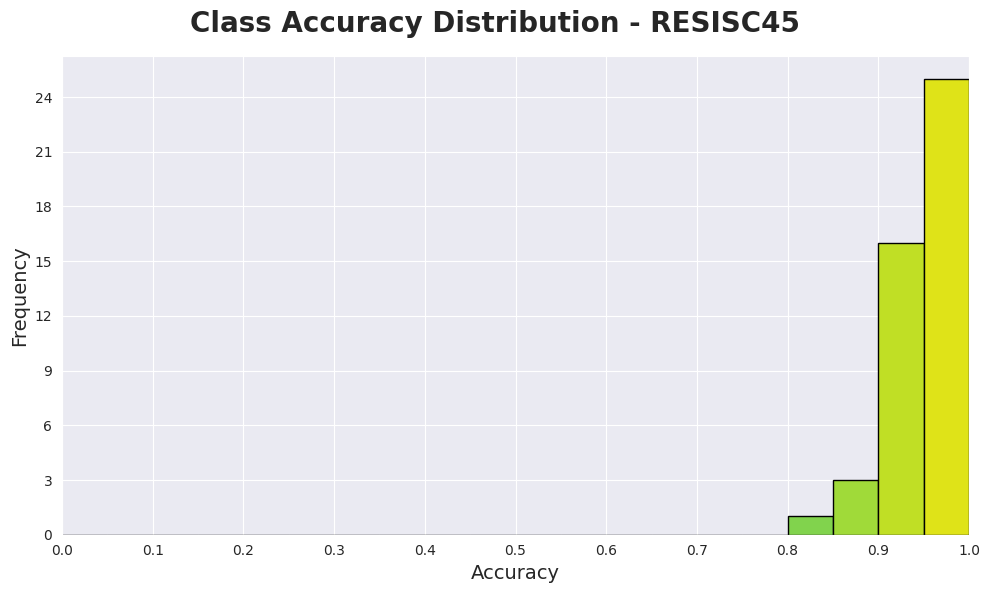

In [75]:
plot_per_class_accuracies(resisc45_per_class_acc, "RESISC45", num_bins=20)

#### Food-101

In [76]:
vit_food101 = Backbone(
    model_names["ViT"],
    num_classes=len(food101_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [77]:
get_model_params(vit_food101)

Parameters: 85.88M


In [78]:
food101_loss, food101_acc, food101_per_class_acc, _, _, _ = train_model(
    vit_food101,
    food101_train,
    config,
    "vit",
    val=food101_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

 98%|█████████▊| 893/908 [05:12<00:04,  3.02it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 395/395 [01:38<00:00,  4.01it/s]


Epochs: 1/15 | train_loss: 4.1753 | train_acc: 0.1201 | val_loss: 3.1387 | val_acc: 0.5098


100%|██████████| 395/395 [01:42<00:00,  3.86it/s]


Epochs: 2/15 | train_loss: 1.9008 | train_acc: 0.6161 | val_loss: 0.9718 | val_acc: 0.7874


100%|██████████| 908/908 [05:00<00:00,  3.02it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 395/395 [01:41<00:00,  3.88it/s]


Epochs: 3/15 | train_loss: 0.9053 | train_acc: 0.7858 | val_loss: 0.7100 | val_acc: 0.8184


100%|██████████| 395/395 [01:38<00:00,  4.01it/s]


Epochs: 4/15 | train_loss: 0.5215 | train_acc: 0.8707 | val_loss: 0.6822 | val_acc: 0.8244


100%|██████████| 395/395 [01:38<00:00,  3.99it/s]


Epochs: 5/15 | train_loss: 0.2661 | train_acc: 0.9350 | val_loss: 0.6986 | val_acc: 0.8247


100%|██████████| 395/395 [01:40<00:00,  3.93it/s]


Epochs: 6/15 | train_loss: 0.1340 | train_acc: 0.9682 | val_loss: 0.7641 | val_acc: 0.8198


100%|██████████| 395/395 [01:38<00:00,  4.00it/s]


Epochs: 7/15 | train_loss: 0.0679 | train_acc: 0.9853 | val_loss: 0.7781 | val_acc: 0.8260


100%|██████████| 395/395 [01:38<00:00,  3.99it/s]


Epochs: 8/15 | train_loss: 0.0314 | train_acc: 0.9936 | val_loss: 0.8158 | val_acc: 0.8260


100%|██████████| 395/395 [01:41<00:00,  3.90it/s]

Epochs: 9/15 | train_loss: 0.0135 | train_acc: 0.9976 | val_loss: 0.8572 | val_acc: 0.8251
Early stopping triggered. Stopping training and saving the model...


In [79]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101, food101_test, config
)

100%|██████████| 395/395 [01:38<00:00,  3.99it/s]


test_loss: 0.5917 | test_acc: 0.8723


In [80]:
food101_accs.append(food101_acc)

In [81]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 1.0),
 ('oysters', 0.984),
 ('pad thai', 0.984),
 ('pizza', 0.976),
 ('macarons', 0.972)]

In [82]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.608),
 ('pork chop', 0.66),
 ('tuna tartare', 0.684),
 ('apple pie', 0.696),
 ('ceviche', 0.696)]

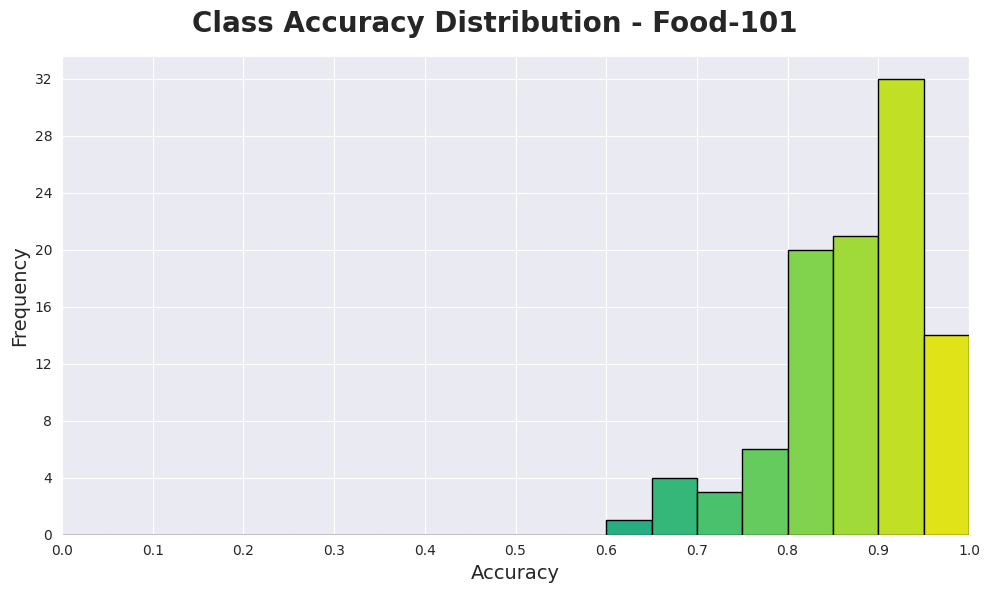

In [83]:
plot_per_class_accuracies(food101_per_class_acc, "Food-101", num_bins=20)

#### FER2013

In [84]:
vit_fer2013 = Backbone(
    model_names["ViT"],
    num_classes=len(fer2013_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [85]:
get_model_params(vit_fer2013)

Parameters: 85.80M


In [86]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc, _, _, _ = train_model(
    vit_fer2013,
    fer2013_train,
    config,
    "vit",
    val=fer2013_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 57/57 [00:06<00:00,  8.73it/s]


Epochs: 1/15 | train_loss: 1.5242 | train_acc: 0.4132 | val_loss: 1.1339 | val_acc: 0.5729


100%|██████████| 57/57 [00:06<00:00,  8.77it/s]


Epochs: 2/15 | train_loss: 1.1190 | train_acc: 0.5765 | val_loss: 0.9622 | val_acc: 0.6459


100%|██████████| 516/516 [01:47<00:00,  4.78it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 57/57 [00:06<00:00,  8.66it/s]


Epochs: 3/15 | train_loss: 0.9393 | train_acc: 0.6493 | val_loss: 0.9027 | val_acc: 0.6598


100%|██████████| 57/57 [00:06<00:00,  8.70it/s]


Epochs: 4/15 | train_loss: 0.7858 | train_acc: 0.7149 | val_loss: 0.9044 | val_acc: 0.6787


100%|██████████| 57/57 [00:06<00:00,  8.55it/s]


Epochs: 5/15 | train_loss: 0.5636 | train_acc: 0.7987 | val_loss: 0.9743 | val_acc: 0.6746


100%|██████████| 57/57 [00:06<00:00,  8.71it/s]


Epochs: 6/15 | train_loss: 0.3372 | train_acc: 0.8858 | val_loss: 1.0869 | val_acc: 0.6941


100%|██████████| 57/57 [00:06<00:00,  8.71it/s]


Epochs: 7/15 | train_loss: 0.1763 | train_acc: 0.9447 | val_loss: 1.2891 | val_acc: 0.6927


100%|██████████| 57/57 [00:06<00:00,  8.69it/s]

Epochs: 8/15 | train_loss: 0.0929 | train_acc: 0.9727 | val_loss: 1.4373 | val_acc: 0.7019
Early stopping triggered. Stopping training and saving the model...


In [87]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013, fer2013_test, config
)

100%|██████████| 57/57 [00:06<00:00,  8.63it/s]

test_loss: 1.3129 | test_acc: 0.7091


In [88]:
fer2013_accs.append(fer2013_acc)

In [89]:
fer2013_per_class_acc

{'angry': 0.6232179226069247,
 'disgust': 0.6727272727272727,
 'fear': 0.5340909090909091,
 'happy': 0.8919226393629124,
 'sad': 0.5808080808080808,
 'surprise': 0.7884615384615384,
 'neutral': 0.7396166134185304}

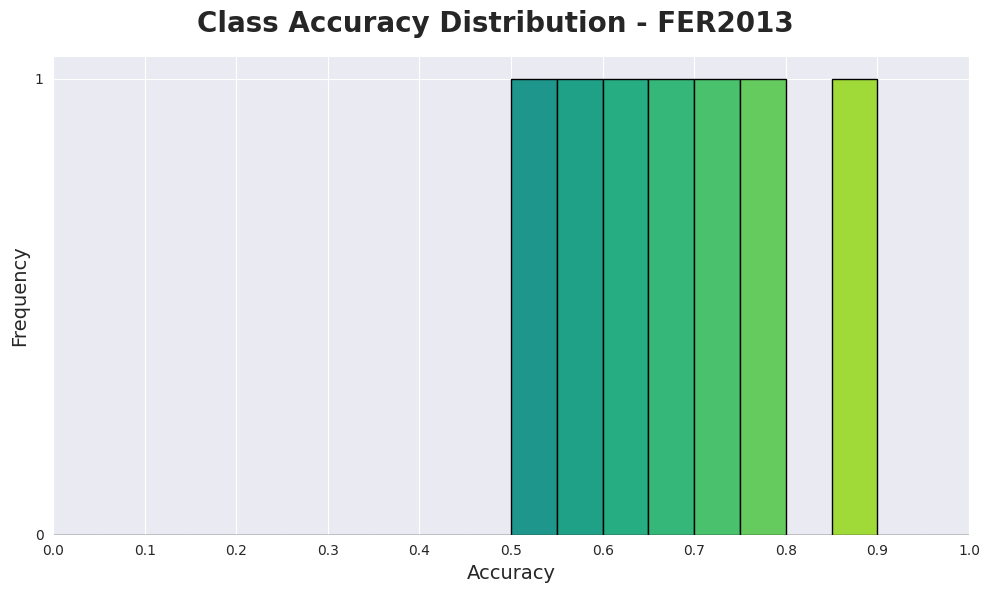

In [90]:
plot_per_class_accuracies(fer2013_per_class_acc, "FER2013", num_bins=20)

#### PCam

In [91]:
vit_pcam = Backbone(
    model_names["ViT"],
    num_classes=len(pcam_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [92]:
get_model_params(vit_pcam)

Parameters: 85.80M


In [93]:
pcam_loss, pcam_acc, pcam_per_class_acc, _, _, _ = train_model(
    vit_pcam,
    pcam_train,
    config,
    "vit",
    val=pcam_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 512/512 [01:04<00:00,  7.99it/s]


Epochs: 1/15 | train_loss: 0.1906 | train_acc: 0.9247 | val_loss: 0.3423 | val_acc: 0.8871


100%|██████████| 512/512 [01:03<00:00,  8.07it/s]


Epochs: 2/15 | train_loss: 0.1208 | train_acc: 0.9564 | val_loss: 0.3991 | val_acc: 0.8857


100%|██████████| 4711/4711 [17:09<00:00,  4.58it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 512/512 [01:03<00:00,  8.09it/s]


Epochs: 3/15 | train_loss: 0.0860 | train_acc: 0.9696 | val_loss: 0.3434 | val_acc: 0.8960


100%|██████████| 512/512 [01:03<00:00,  8.01it/s]


Epochs: 4/15 | train_loss: 0.0644 | train_acc: 0.9776 | val_loss: 0.3651 | val_acc: 0.8919


100%|██████████| 512/512 [01:04<00:00,  7.98it/s]


Epochs: 5/15 | train_loss: 0.0411 | train_acc: 0.9857 | val_loss: 0.4483 | val_acc: 0.8978


100%|██████████| 512/512 [01:03<00:00,  8.07it/s]

Epochs: 6/15 | train_loss: 0.0264 | train_acc: 0.9909 | val_loss: 0.5160 | val_acc: 0.8881
Early stopping triggered. Stopping training and saving the model...


In [94]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(vit_pcam, pcam_test, config)

100%|██████████| 512/512 [01:03<00:00,  8.08it/s]

test_loss: 0.5302 | test_acc: 0.8716


In [95]:
pcam_accs.append(pcam_acc)

In [96]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9649197730461839,
 'lymph node tumor tissue': 0.7781644989924895}

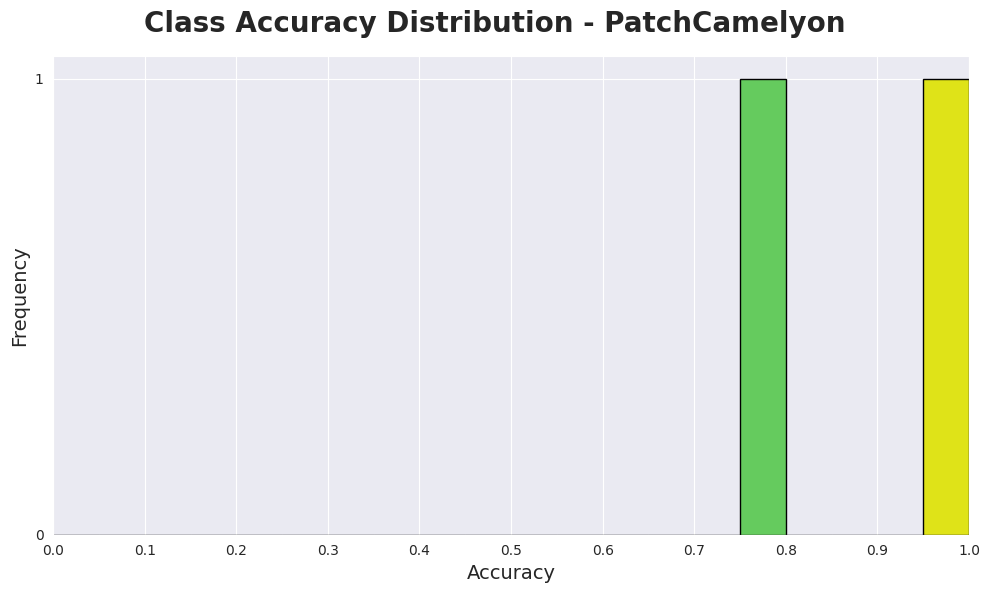

In [97]:
plot_per_class_accuracies(pcam_per_class_acc, "PatchCamelyon", num_bins=20)

#### SUN397

In [98]:
vit_sun397 = Backbone(
    model_names["ViT"],
    num_classes=len(sun397_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
get_model_params(vit_sun397)

Parameters: 86.10M


In [100]:
sun397_loss, sun397_acc, sun397_per_class_acc, _, _, _ = train_model(
    vit_sun397,
    sun397_train,
    config,
    "vit",
    val=sun397_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 170/170 [00:52<00:00,  3.22it/s]


Epochs: 1/15 | train_loss: 5.3248 | train_acc: 0.1125 | val_loss: 4.2605 | val_acc: 0.3059


100%|██████████| 170/170 [00:52<00:00,  3.27it/s]


Epochs: 2/15 | train_loss: 2.8803 | train_acc: 0.4763 | val_loss: 1.6696 | val_acc: 0.6589


100%|██████████| 1368/1368 [08:33<00:00,  2.66it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 170/170 [00:52<00:00,  3.26it/s]


Epochs: 3/15 | train_loss: 1.3820 | train_acc: 0.6917 | val_loss: 0.9740 | val_acc: 0.7535


100%|██████████| 170/170 [00:52<00:00,  3.25it/s]


Epochs: 4/15 | train_loss: 0.8037 | train_acc: 0.7961 | val_loss: 0.8472 | val_acc: 0.7682


100%|██████████| 170/170 [00:52<00:00,  3.26it/s]


Epochs: 5/15 | train_loss: 0.4688 | train_acc: 0.8733 | val_loss: 0.8378 | val_acc: 0.7757


100%|██████████| 170/170 [00:52<00:00,  3.25it/s]


Epochs: 6/15 | train_loss: 0.2626 | train_acc: 0.9300 | val_loss: 0.9091 | val_acc: 0.7675


100%|██████████| 170/170 [00:52<00:00,  3.25it/s]


Epochs: 7/15 | train_loss: 0.1465 | train_acc: 0.9622 | val_loss: 0.9694 | val_acc: 0.7711


100%|██████████| 170/170 [00:52<00:00,  3.25it/s]


Epochs: 8/15 | train_loss: 0.0748 | train_acc: 0.9820 | val_loss: 1.0424 | val_acc: 0.7661


100%|██████████| 170/170 [00:51<00:00,  3.27it/s]


Epochs: 9/15 | train_loss: 0.0369 | train_acc: 0.9922 | val_loss: 1.0881 | val_acc: 0.7700


100%|██████████| 170/170 [00:52<00:00,  3.25it/s]

Epochs: 10/15 | train_loss: 0.0154 | train_acc: 0.9976 | val_loss: 1.1350 | val_acc: 0.7672
Early stopping triggered. Stopping training and saving the model...


In [101]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397, sun397_test, config
)

100%|██████████| 340/340 [01:48<00:00,  3.13it/s]


test_loss: 1.1182 | test_acc: 0.7708


In [102]:
sun397_accs.append(sun397_acc)

In [103]:
get_top_5_accuracies(sun397_per_class_acc)

[('batters box', 1.0),
 ('bullring', 1.0),
 ('oast house', 1.0),
 ('train railway', 1.0),
 ('underwater (coral reef)', 1.0)]

In [104]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('inn (outdoor)', 0.20689655172413793),
 ('factory (indoor)', 0.21739130434782608),
 ('recreation room', 0.2222222222222222),
 ('gift shop', 0.25),
 ('library (outdoor)', 0.2857142857142857)]

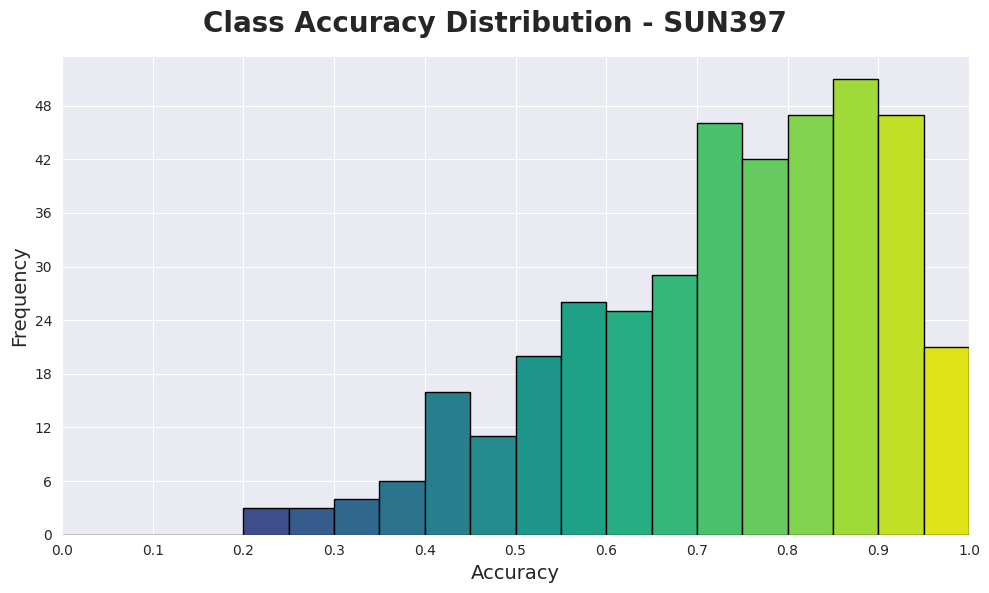

In [105]:
plot_per_class_accuracies(sun397_per_class_acc, "SUN397", num_bins=20)

#### DTD

In [106]:
vit_dtd = Backbone(
    model_names["ViT"],
    num_classes=len(dtd_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [107]:
get_model_params(vit_dtd)

Parameters: 85.83M


In [108]:
dtd_loss, dtd_acc, dtd_per_class_acc, _, _, _ = train_model(
    vit_dtd,
    dtd_train,
    config,
    "vit",
    val=dtd_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 6/6 [00:01<00:00,  3.49it/s]


Epochs: 1/15 | train_loss: 3.9986 | train_acc: 0.0339 | val_loss: 3.7613 | val_acc: 0.0665


100%|██████████| 6/6 [00:01<00:00,  3.77it/s]


Epochs: 2/15 | train_loss: 3.5582 | train_acc: 0.1244 | val_loss: 3.1012 | val_acc: 0.3644


100%|██████████| 61/61 [00:21<00:00,  2.80it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Epochs: 3/15 | train_loss: 2.5497 | train_acc: 0.4446 | val_loss: 2.0037 | val_acc: 0.6303


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Epochs: 4/15 | train_loss: 1.3928 | train_acc: 0.7235 | val_loss: 1.1683 | val_acc: 0.7181


100%|██████████| 6/6 [00:01<00:00,  3.70it/s]


Epochs: 5/15 | train_loss: 0.6678 | train_acc: 0.8797 | val_loss: 0.8955 | val_acc: 0.7633


100%|██████████| 6/6 [00:01<00:00,  3.73it/s]


Epochs: 6/15 | train_loss: 0.3072 | train_acc: 0.9614 | val_loss: 0.8021 | val_acc: 0.7899


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Epochs: 7/15 | train_loss: 0.1289 | train_acc: 0.9905 | val_loss: 0.7281 | val_acc: 0.7979


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Epochs: 8/15 | train_loss: 0.0612 | train_acc: 0.9972 | val_loss: 0.7348 | val_acc: 0.7926


100%|██████████| 6/6 [00:01<00:00,  3.56it/s]


Epochs: 9/15 | train_loss: 0.0335 | train_acc: 0.9995 | val_loss: 0.7036 | val_acc: 0.7926


100%|██████████| 6/6 [00:01<00:00,  3.69it/s]


Epochs: 10/15 | train_loss: 0.0241 | train_acc: 1.0000 | val_loss: 0.7041 | val_acc: 0.8005


100%|██████████| 6/6 [00:01<00:00,  3.58it/s]


Epochs: 11/15 | train_loss: 0.0192 | train_acc: 1.0000 | val_loss: 0.6968 | val_acc: 0.8005


100%|██████████| 6/6 [00:01<00:00,  3.68it/s]


Epochs: 12/15 | train_loss: 0.0163 | train_acc: 1.0000 | val_loss: 0.6990 | val_acc: 0.7952


100%|██████████| 6/6 [00:01<00:00,  3.67it/s]


Epochs: 13/15 | train_loss: 0.0155 | train_acc: 1.0000 | val_loss: 0.6991 | val_acc: 0.8005


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]


Epochs: 14/15 | train_loss: 0.0147 | train_acc: 1.0000 | val_loss: 0.6989 | val_acc: 0.7952


100%|██████████| 6/6 [00:01<00:00,  3.65it/s]

Epochs: 15/15 | train_loss: 0.0145 | train_acc: 1.0000 | val_loss: 0.6988 | val_acc: 0.8005


In [109]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(vit_dtd, dtd_test, config)

100%|██████████| 30/30 [00:08<00:00,  3.68it/s]

test_loss: 0.7791 | test_acc: 0.7867


In [110]:
dtd_accs.append(dtd_acc)

In [111]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 1.0),
 ('cobwebbed', 0.975),
 ('chequered', 0.95),
 ('scaly', 0.95),
 ('studded', 0.95)]

In [112]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.425),
 ('stained', 0.45),
 ('woven', 0.45),
 ('pitted', 0.625),
 ('porous', 0.625)]

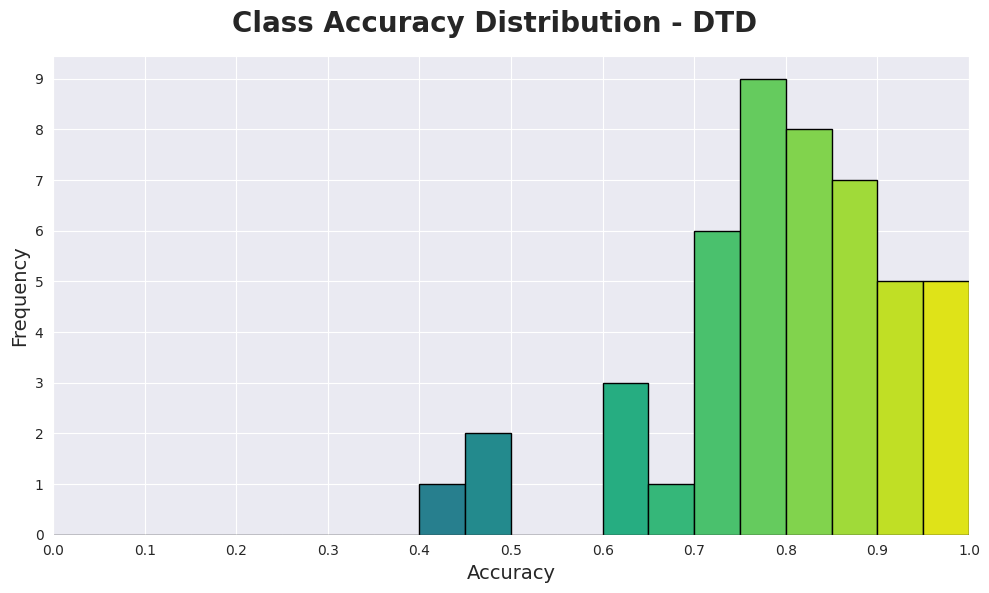

In [113]:
plot_per_class_accuracies(dtd_per_class_acc, "DTD", num_bins=20)

### Results

Display the results of the analysis in dataframe.

In [114]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [115]:
labels = ["RESISC45", "Food-101", "FER2013", "PatchCamelyon", "SUN397", "DTD"]

In [116]:
acc_dict = create_accuracy_dict(results, labels)

In [117]:
df = pd.DataFrame(
    results, columns=["fine-tuning with data augmentations"], index=labels
)
df

,fine-tuning with data augmentations
RESISC45,0.950635
Food-101,0.872317
FER2013,0.709111
PatchCamelyon,0.871582
SUN397,0.770805
DTD,0.786702
